<a href="https://colab.research.google.com/github/franz6ko/natural-lenguage-processing/blob/master/challenge_2_bot_dnn_spacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bot basado en reglas con DNN + Spacy

### 1 - Dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

     |████████████████████████████████| 6.4 MB 8.2 MB/s 
     |████████████████████████████████| 456 kB 56.1 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 10.1 MB 32.9 MB/s 
     |████████████████████████████████| 623 kB 69.7 MB/s 
     |████████████████████████████████| 342 kB 7.0 MB/s 


In [2]:
import json
import string
import random 
import numpy as np

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [3]:
import stanza
import spacy_stanza

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

2021-09-27 13:00:15 INFO: Downloading default packages for language: es (Spanish)...


2021-09-27 13:02:07 INFO: Finished downloading models and saved to /root/stanza_resources.
2021-09-27 13:02:07 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2021-09-27 13:02:07 INFO: Use device: cpu
2021-09-27 13:02:07 INFO: Loading: tokenize
2021-09-27 13:02:07 INFO: Loading: mwt
2021-09-27 13:02:07 INFO: Loading: pos
2021-09-27 13:02:07 INFO: Loading: lemma
2021-09-27 13:02:07 INFO: Loading: depparse
2021-09-27 13:02:08 INFO: Loading: ner
2021-09-27 13:02:09 INFO: Done loading processors!


### 2 - Preprocesamiento de texto

In [4]:
import re
import unicodedata

def preprocess_clean_text(text):    
    # sacar tildes de las palabras
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntiación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

### 3 - Diccionario de entrada

In [31]:
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "Buenos días", "Buenas tardes"],
              "responses": ["Hola, ¿En qué podemos asistirlo?"],
             },
            {"tag": "contacto",
              "patterns": ["contacto", "número de contacto", "número de teléfono", "número de whatsapp", "whatsapp", "celular", "llamar", "comunicar", "hablar"],
              "responses": ["Puede comunicarse con nosotros vía telefónica o Whatsapp al 261-XXX-XXXX"]
             },
            {"tag": "presupuesto",
              "patterns": ["Quisiera presupuestar un trabajo", "¿Podrían presupuestarme un trabajo?", "Necesito un presupuesto", "Cuánto me saldría hacer este trabajo", "Cuánto cuesta hacer esto"],
              "responses": ["Para presupuestos, comunicarse vía mail a xxx@gmail.com"]
             },
            {"tag": "estado de trabajo",
              "patterns": ["Quisiera saber si mi trabajo está listo", "Cuándo va a estar listo mi trabajo", "Cuándo puedo retirar mi trabajo", "estado"],
              "responses": ["Para consultar sobre el estado de un trabajo, ingrese a continuación en número de trabajo y el apellido de la persona que lo encargó"]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas", "pagar"],
              "responses": ["En el siguiente link podrás encontrar los beneficios y formas de pago vigentes"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Gracias por confiar en nosotros, estamos atentos a cualquier otra consulta"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

#### Armo mi conjunto de tokens (words) y conjunto de entradas-salidas (pattern-tag)

In [32]:
words = []
classes = []
doc_X = []
doc_y = []

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

#### Usando mi conjunto de tokens (words), aplico OHE a mis entradas. También aplico OHE a mis salidas para obtener un vector de clases

In [33]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0]
X: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0]
X: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0]
X: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0] y: [0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

### 5 - Entrenamiento del modelo

In [34]:
model = Sequential()
model.add(Dense(128, input_shape=(train_X.shape[1],), activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(train_y.shape[1], activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               5760      
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 390       
Total params: 14,406
Trainable params: 14,406
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 950ms/step - loss: 1.8696 - accuracy: 0.1071
Epoch 2/200
1/1 [==============================] - 0s 8ms/step - loss: 1.8299 - accuracy: 0.2500
Epoch 3/200
1/1 [==============================] - 0s 5ms/step - loss: 1.7737 - accuracy: 0.3214
Epoch 4/200
1/1 [==============================] - 0s 5ms/step - loss: 1.7891 - accuracy: 0.2857
Epoch 5/200
1/1 [==============================] - 0s 4ms/step - loss: 1.8178 - accuracy: 0.2500
Epoch 6/200
1/1 [==============================] - 0s 5ms/step - loss: 1.7591 - accuracy: 0.2500
Epoch 7/200
1/1 [==============================] - 0s 7ms/step - loss: 1.7442 - accuracy: 0.1786
Epoch 8/200
1/1 [==============================] - 0s 7ms/step - loss: 1.7010 - accuracy: 0.3214
Epoch 9/200
1/1 [==============================] - 0s 8ms/step - loss: 1.7349 - accuracy: 0.2857
Epoch 10/200
1/1 [==============================] - 0s 8ms/step - loss: 1.6790 - accuracy: 0.3571
Epoch 11/200
1/1 [=========

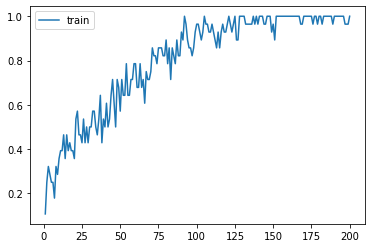

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

#### Guardar modelo para producción

In [37]:
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [38]:
def text_to_tokens(text): 
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    return lemma_tokens

def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        for r in y_pred:
            return_list.append(labels[r[0]])
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        if i["tag"] == tag:
            result = "BOT: " + random.choice(i["responses"])
            break
    return result

In [43]:
while True:
    message = input("")
    if message == "":
      break
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print(result)
    else:
        print("Perdón, no comprendo la pregunta.")

Buenos días
BOT: Hola, ¿En qué podemos asistirlo?
Quisiera saber cuanto me costaría hacer unas planchetas
BOT: Para presupuestos, comunicarse vía mail a xxx@gmail.com
Quiero saber si puedo retirar el trabajo que encargué ayer
BOT: Para consultar sobre el estado de un trabajo, ingrese a continuación en número de trabajo y el apellido de la persona que lo encargó
Quisiera hablar con alguien de la oficina
BOT: Puede comunicarse con nosotros vía telefónica o Whatsapp al 261-XXX-XXXX
Aceptan cuotas?
BOT: En el siguiente link podrás encontrar los beneficios y formas de pago vigentes
Muchas gracias, mañana voy entonces
BOT: Gracias por confiar en nosotros, estamos atentos a cualquier otra consulta



#### Test con gradio

In [44]:
import sys
!{sys.executable} -m pip install gradio --quiet

     |████████████████████████████████| 3.4 MB 8.0 MB/s 
     |████████████████████████████████| 206 kB 58.2 MB/s 
     |████████████████████████████████| 1.9 MB 51.8 MB/s 
     |████████████████████████████████| 3.0 MB 59.4 MB/s 
     |████████████████████████████████| 961 kB 54.3 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 


In [49]:
import gradio as gr

def bot_response(human_text):
    print(human_text)
    intents = pred_class(human_text.lower(), words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
    else:
        result = "Perdón, no comprendo la pregunta."
    print(result)
    return result

iface = gr.Interface(
    fn=bot_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://37755.gradio.app
Interface loading below...


Hola
BOT: Hola, ¿En qué podemos asistirlo?
Necesito que me presupuesten unas campanas de metal
BOT: Para presupuestos, comunicarse vía mail a xxx@gmail.com
Gracias
BOT: Gracias por confiar en nosotros, estamos atentos a cualquier otra consulta


KeyboardInterrupt: ignored